# TRIÈST-BASE: Streaming Triangle Counting

This notebook implements the **TRIÈST-BASE** algorithm (De Stefani et al., KDD 2016)
for estimating the number of triangles in a graph stream.

We will:

1. Load an **undirected, unweighted graph** from an edge-list file in `data/`.
2. Implement **reservoir sampling** on edges.
3. Implement **TRIÈST-BASE** to estimate:
   - the **global** number of triangles,
   - **local** triangle counts per node (optional, but useful).
4. Compute the **exact** number of triangles with NetworkX (if the graph is not too large).
5. Compare the estimated vs. exact results and analyse what they mean.
6. Answer the **bonus questions** about implementation, parallelization, unbounded streams and deletions.


In [11]:
import random
import time
from collections import defaultdict
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
random.seed(42)

# Data directory and file (adapt the name to your dataset)
DATA_DIR = Path("data")
EDGE_LIST_FILE = DATA_DIR / "git_web_ml" / "musae_git_edges.csv"

print("Data directory:", DATA_DIR.resolve())
print("Edge list file:", EDGE_LIST_FILE)


Data directory: /Users/woland02/VsCode/Data-Mining-Project/homework3/data
Edge list file: data/git_web_ml/musae_git_edges.csv


## Loading the graph as an edge stream

We assume the dataset is stored as a text **edge list**:

- one edge per line,
- format: `u v` (separated by whitespace or a chosen delimiter),
- optional comment lines starting with `#`.

We treat the graph as:

- **undirected**: edge `(u, v)` is the same as `(v, u)`,
- **simple**: we ignore self-loops and collapse multiple edges into one.


In [12]:
def edge_stream_from_file(path, delimiter=None, comment_prefix="#"):
    """
    Generator that yields an undirected edge (u, v) for each line in a text edge-list file.

    - path: path to the file.
    - delimiter: separator between u and v (None = any whitespace).
    - comment_prefix: lines starting with this prefix are ignored.
    """
    seen_edges = set()  # to avoid counting duplicates

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if comment_prefix and line.startswith(comment_prefix):
                continue

            parts = line.split() if delimiter is None else line.split(delimiter)
            if len(parts) < 2:
                continue

            u, v = parts[0], parts[1]

            # Ignore self-loops
            if u == v:
                continue

            # Undirected normalization: always keep (min, max)
            if u > v:
                u, v = v, u

            edge = (u, v)
            if edge in seen_edges:
                continue  # skip duplicates if they exist

            seen_edges.add(edge)
            yield edge


## Exact triangle counting (for evaluation)

Before using TRIÈST-BASE, we implement a helper that:

1. Loads the whole graph into memory as a NetworkX `Graph` (undirected).
2. Uses `nx.triangles` to compute:
   - the number of triangles **adjacent to each node**,
   - the **total** number of triangles in the graph.

This is only feasible when the graph is **not too large**, but it is very useful
for validating our streaming algorithm.


In [13]:
def load_graph_networkx(path, delimiter=None, comment_prefix="#"):
    """
    Load the whole graph into a NetworkX undirected Graph.
    """
    G = nx.Graph()
    for u, v in edge_stream_from_file(path, delimiter=delimiter, comment_prefix=comment_prefix):
        G.add_edge(u, v)
    return G


def exact_triangle_count(G):
    """
    Return:
      - global number of triangles,
      - dictionary node -> number of incident triangles.
    """
    local_triangles = nx.triangles(G)
    global_triangles = sum(local_triangles.values()) // 3
    return global_triangles, local_triangles


## TRIÈST-BASE – Conceptual summary

We process edges as a **stream**:  
`e₁, e₂, ..., e_t, ...`.

We maintain:

- a **sample** `S` of at most `M` edges (fixed memory),
- a **global counter** `τ` for triangles **inside the sample**,
- **local counters** `τ_u` for triangles touching node `u` in the sample.

### Reservoir sampling on edges

Let `t` be the number of edges seen so far.

- If `t ≤ M`:
  - we insert the new edge into the sample.

- If `t > M`:
  - we insert the new edge with probability `M / t`,
  - if we insert it, we randomly remove one edge currently in the sample
    to keep `|S| = M`.

### Updating triangle counters

Whenever we **add** an edge `(u, v)` to the sample:

1. We compute the set of common neighbors in the sampled graph:

   \[
   C = N_S(u) \cap N_S(v)
   \]

2. For each `c ∈ C` we have a triangle `(u, v, c)` in the sample.

   For each such triangle we update:

   - `τ     += 1`
   - `τ_u   += 1`
   - `τ_v   += 1`
   - `τ_c   += 1`

When we **remove** an edge `(u, v)` from the sample, we do the same
but with `-1` instead of `+1`.

### Estimator

Let `t` be the total number of edges processed.

The correction factor is:

\[
\xi^{(t)} =
\begin{cases}
1, & t \le M \\
\max \Big(1, \dfrac{t(t-1)(t-2)}{M(M-1)(M-2)} \Big), & t > M
\end{cases}
\]

The **estimated global number of triangles** is:

\[
\hat{T} = \xi^{(t)} \cdot τ
\]

The **estimated local triangles** for a node `u`:

\[
\hat{T}_u = \xi^{(t)} \cdot τ_u
\]


In [14]:
class TriestBase:
    """
    Implementation of TRIÈST-BASE for insertion-only edge streams.

    Parameters
    ----------
    M : int
        Maximum sample size (number of edges kept in memory).
    """

    def __init__(self, M: int):
        if M < 6:
            raise ValueError("M must be >= 6 for a meaningful correction factor.")
        self.M = M

        # Sample of edges: set of (u, v) with u < v
        self.sample = set()

        # Triangle counters inside the sample
        self.tau_global = 0
        self.tau_local = defaultdict(int)

        # Number of edges processed so far
        self.t = 0

        # Adjacency structure for the sampled graph
        self.neighbors = defaultdict(set)

    # ---------- Public API ---------- #

    def process_edge(self, u, v):
        """
        Process a single (undirected) edge (u, v) from the stream.
        """
        if u == v:
            return  # ignore self-loops

        # Normalize direction
        if u > v:
            u, v = v, u

        self.t += 1  # new stream edge

        if self._should_sample_current_edge():
            if len(self.sample) >= self.M:
                self._remove_random_edge()
            self._add_edge_to_sample(u, v)

    def process_stream(self, edge_iterable, show_progress=False, total_edges=None):
        """
        Process an entire edge stream (an iterable of (u, v)).
        """
        iterator = edge_iterable
        if show_progress:
            iterator = tqdm(edge_iterable, total=total_edges, desc="Processing stream")

        for u, v in iterator:
            self.process_edge(u, v)

    def get_global_estimate(self):
        """
        Return the estimated global number of triangles.
        """
        return self._xi_t() * self.tau_global

    def get_local_estimates(self):
        """
        Return a dict: node -> estimated number of incident triangles.
        """
        xi = self._xi_t()
        return {u: xi * v for u, v in self.tau_local.items()}

    # ---------- Internal helpers ---------- #

    def _xi_t(self):
        """
        Correction factor xi^(t) from TRIÈST-BASE.
        """
        if self.t <= self.M:
            return 1.0
        t = self.t
        M = self.M
        num = t * (t - 1) * (t - 2)
        den = M * (M - 1) * (M - 2)
        return max(1.0, num / den)

    def _should_sample_current_edge(self):
        """
        Decide whether the current edge should be added to the sample.
        """
        if self.t <= self.M:
            return True
        prob = self.M / self.t
        return random.random() < prob

    def _remove_random_edge(self):
        """
        Remove a random edge from the sample and update triangle counters.
        """
        u, v = random.choice(tuple(self.sample))

        # Update counters for triangles that disappear
        self._update_triangle_counters(u, v, sign=-1)

        # Remove edge from sample and adjacency
        self.sample.remove((u, v))
        self.neighbors[u].remove(v)
        self.neighbors[v].remove(u)

        if not self.neighbors[u]:
            del self.neighbors[u]
        if not self.neighbors[v]:
            del self.neighbors[v]

    def _add_edge_to_sample(self, u, v):
        """
        Add a new edge to the sample and update triangle counters.
        """
        self._update_triangle_counters(u, v, sign=+1)

        self.sample.add((u, v))
        self.neighbors[u].add(v)
        self.neighbors[v].add(u)

    def _update_triangle_counters(self, u, v, sign):
        """
        Update global and local triangle counters when edge (u, v) is
        added (sign=+1) or removed (sign=-1) from the sample.
        """
        neighbors_u = self.neighbors.get(u, set())
        neighbors_v = self.neighbors.get(v, set())
        common_neighbors = neighbors_u.intersection(neighbors_v)

        for c in common_neighbors:
            # One triangle (u, v, c) appears or disappears
            self.tau_global += sign
            self.tau_local[u] += sign
            self.tau_local[v] += sign
            self.tau_local[c] += sign

            if self.tau_local[c] == 0:
                self.tau_local.pop(c, None)

        if self.tau_local[u] == 0:
            self.tau_local.pop(u, None)
        if self.tau_local[v] == 0:
            self.tau_local.pop(v, None)


## Quick sanity check on a toy graph

Before running on the real dataset, we test TRIÈST-BASE on a very small graph
where we know the exact number of triangles.
If we set `M` ≥ number of edges, the sample will contain all edges and the
algorithm should behave like exact counting.


In [15]:
# Simple toy graph:
# triangle on nodes 1, 2, 3 and a 4-node cycle without triangles
toy_edges = [
    ("1", "2"), ("2", "3"), ("1", "3"),
    ("3", "4"), ("4", "5"), ("5", "6"), ("6", "3")
]

G_toy = nx.Graph()
G_toy.add_edges_from(toy_edges)
exact_global_toy, _ = exact_triangle_count(G_toy)
print("Exact global triangles (toy):", exact_global_toy)

M_toy = len(toy_edges)
triest_toy = TriestBase(M=M_toy)

for u, v in toy_edges:
    triest_toy.process_edge(u, v)

estimate_global_toy = triest_toy.get_global_estimate()
print("TRIÈST-BASE estimate (toy):", estimate_global_toy)


Exact global triangles (toy): 1
TRIÈST-BASE estimate (toy): 1.0


## Running TRIÈST-BASE on the chosen dataset

Now we run TRIÈST-BASE on the actual graph stored in `EDGE_LIST_FILE`.

Steps:

1. Choose a **sample size `M`**:
   - larger `M` → more accurate but more memory,
   - smaller `M` → faster, less memory, but higher variance.
2. Run TRIÈST-BASE on the stream of edges.
3. Optionally compute the **exact** number of triangles with NetworkX.


In [16]:
def run_experiment(
    path,
    M,
    delimiter=None,
    comment_prefix="#",
    compute_exact=True,
    show_progress=True
):
    """
    Run TRIÈST-BASE on a given edge-list file.

    Returns a dictionary with:
      - estimate_global
      - exact_global (if computed)
      - relative_error (if exact is available)
      - time_triest
      - time_exact (if exact is computed)
    """
    print(f"=== Experiment on {path.name} ===")
    print(f"Sample size M = {M}")

    # --- TRIÈST-BASE ---
    triest = TriestBase(M=M)

    start = time.perf_counter()
    triest.process_stream(
        edge_stream_from_file(path, delimiter=delimiter, comment_prefix=comment_prefix),
        show_progress=show_progress
    )
    time_triest = time.perf_counter() - start

    estimate_global = triest.get_global_estimate()
    print(f"\n[TRIÈST] Estimated global triangles: {estimate_global:.2f}")
    print(f"[TRIÈST] Time: {time_triest:.3f} s")

    results = {
        "estimate_global": estimate_global,
        "time_triest": time_triest,
    }

    # --- Exact counting (optional) ---
    if compute_exact:
        print("\nComputing exact triangle count with NetworkX...")
        start = time.perf_counter()
        G = load_graph_networkx(path, delimiter=delimiter, comment_prefix=comment_prefix)
        time_load = time.perf_counter() - start

        start = time.perf_counter()
        exact_global, exact_local = exact_triangle_count(G)
        time_exact_count = time.perf_counter() - start

        time_exact = time_load + time_exact_count

        print(f"[Exact] Global triangles: {exact_global}")
        print(f"[Exact] Time (load + count): {time_exact:.3f} s")

        results["exact_global"] = exact_global
        results["time_exact"] = time_exact

        if exact_global > 0:
            rel_error = abs(estimate_global - exact_global) / exact_global
        else:
            rel_error = None

        if rel_error is not None:
            print(f"Relative error: {rel_error:.4f}")
        else:
            print("Relative error: undefined (0 exact triangles).")

        results["relative_error"] = rel_error

    return results


In [19]:
DATA_DIR = Path("data")

results = run_experiment(
    path=EDGE_LIST_FILE,
    M=5000,
    delimiter=",",
    comment_prefix=None,
    compute_exact=True,
    show_progress=True
)

results



=== Experiment on musae_git_edges.csv ===
Sample size M = 5000


Processing stream: 289004it [00:01, 188621.15it/s]



[TRIÈST] Estimated global triangles: 386444.97
[TRIÈST] Time: 1.534 s

Computing exact triangle count with NetworkX...
[Exact] Global triangles: 523810
[Exact] Time (load + count): 0.834 s
Relative error: 0.2622


{'estimate_global': 386444.96720895235,
 'time_triest': 1.5341460830532014,
 'exact_global': 523810,
 'time_exact': 0.833747168071568,
 'relative_error': 0.2622420969264574}

## Interpreting the results

From the previous cell we obtained:

- **Exact global triangle count** `T_exact`,
- **Estimated** triangle count `T_hat` from TRIÈST-BASE,
- The **relative error** `|T_hat - T_exact| / T_exact`,
- Running times for the streaming algorithm and for the exact method.

### What do these numbers mean?

- A **high number of triangles** indicates that the graph has a strong tendency
  to form **closed triplets**, i.e., groups of three nodes all connected to each other.
  This is closely related to the **clustering coefficient** and to the presence of
  tightly-knit communities.

- If the **relative error** is low (for example below 5–10%), the streaming
  algorithm is giving a very good approximation using only a small sample of edges.

- The **gap in running time** between TRIÈST-BASE and the exact method
  gives an idea of why streaming algorithms are useful: as the graph grows,
  exact triangle counting quickly becomes expensive both in time and memory,
  while TRIÈST-BASE only keeps `M` edges in memory.



## Optional: how does the sample size M affect accuracy?

This short experiment repeats TRIÈST-BASE for several values of `M`
and plots the relative error (only if the exact triangle count is available).
We keep it simple and avoid too many extra plots.


Computing exact triangles once...
Exact global triangles: 0

---------------------------
M = 500
Estimate: 0.00, relative error: None

---------------------------
M = 1000
Estimate: 0.00, relative error: None

---------------------------
M = 2000
Estimate: 0.00, relative error: None

---------------------------
M = 5000
Estimate: 0.00, relative error: None


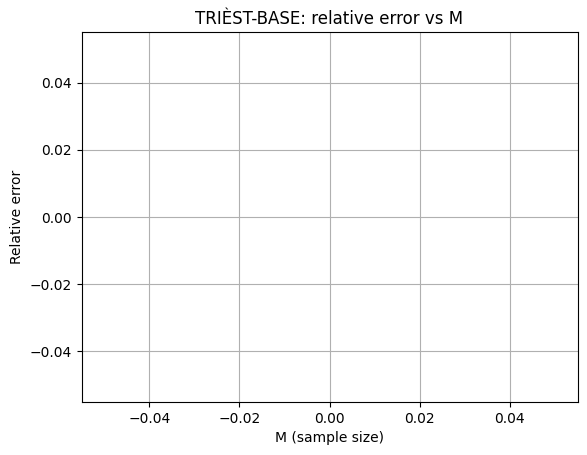

In [20]:
def experiment_vary_M(path, M_values):
    """
    Run TRIÈST-BASE for several sample sizes M and track the relative error.
    """
    print("Computing exact triangles once...")
    G = load_graph_networkx(path)
    exact_global, _ = exact_triangle_count(G)
    print("Exact global triangles:", exact_global)

    errors = []

    for M in M_values:
        print("\n---------------------------")
        print(f"M = {M}")
        triest = TriestBase(M=M)
        start = time.perf_counter()
        triest.process_stream(edge_stream_from_file(path), show_progress=False)
        _ = time.perf_counter() - start

        est = triest.get_global_estimate()
        err = abs(est - exact_global) / exact_global if exact_global > 0 else None
        errors.append(err)
        print(f"Estimate: {est:.2f}, relative error: {err}")

    return M_values, errors


M_values = [500, 1000, 2000, 5000]
Ms_used, errs = experiment_vary_M(EDGE_LIST_FILE, M_values)

plt.figure()
plt.plot(Ms_used, errs, marker="o")
plt.xlabel("M (sample size)")
plt.ylabel("Relative error")
plt.title("TRIÈST-BASE: relative error vs M")
plt.grid(True)
plt.show()


## Bonus questions

### 1. Implementation challenges

Some practical challenges when implementing TRIÈST-BASE were:

- **Maintaining the sample and neighborhoods efficiently**:  
  we must keep the sampled edges in a set and also maintain an adjacency
  structure (`neighbors`) so that we can quickly find common neighbors when
  edges are added or removed.

- **Updating triangle counters correctly on edge removal**:  
  when we drop an edge from the sample due to reservoir sampling,
  we must **decrease** the triangle counters for all triangles that contained
  that edge. This requires recomputing the common neighbors before actually
  removing the edge.

- **Balancing accuracy and memory**:  
  choosing `M` too small yields high variance; choosing it too large may
  make the algorithm slower and more memory-hungry.

### 2. Can the algorithm be parallelized?

TRIÈST-BASE is not trivially parallel **within a single stream**, because:

- Reservoir sampling requires a **global view** of how many edges have been
  seen so far (`t`) and of the current sample size `M`.
- When an edge is added or removed from the sample, we need to update
  triangle counters that depend on the **current sampled graph**.

However, there are some parallelization opportunities:

- We can process **different independent streams or different subgraphs**
  in parallel and then combine the estimates.
- Some operations on adjacency sets (like computing intersections) could
  be parallelized at a lower level.

In practice, a careful design would be needed to keep the sample consistent
across threads or machines.

### 3. Does the algorithm work for unbounded graph streams?

Yes, TRIÈST-BASE is explicitly designed for **unbounded** streams:

- It never needs to know in advance how many edges will arrive.
- It keeps a **fixed-size sample** of edges of size `M`, independent of
  the total length of the stream.
- As time goes on, the correction factor `ξ^(t)` adapts to the current
  number of seen edges `t`.

The quality of the estimate depends on the relation between `M` and the
final size of the stream, but the algorithm itself can keep running forever.

### 4. Does the algorithm support edge deletions?

TRIÈST-BASE, as originally defined, assumes a stream of **insertions only**.

- There is a variant in the paper called **TRIÈST-FD** (Fully Dynamic)
  that supports **edge deletions** as well as insertions.
- TRIÈST-FD uses a slightly different sampling scheme and updates the
  triangle counters in a symmetric way for insertions and deletions.

To extend our implementation to support deletions we would need to:

1. Extend the stream model so that each update is labelled as
   `INSERT(u, v)` or `DELETE(u, v)`.
2. Implement the sampling scheme from TRIÈST-FD, which decides whether
   to keep or discard edges when they are inserted or deleted.
3. Update the triangle counters both when edges enter the sample and
   when they are removed due to deletions, carefully maintaining the
   unbiasedness of the estimator.

In this homework we focus on the simpler insertion-only case, i.e., TRIÈST-BASE.
